# Análises para *Projeto Integrado*

## Autores da análise

| Nome dos Integrantes     | RM            | Turma |
| :----------------------- | :------------ | :---: |
| Alexandre Lima Freitas   | RM 330376     | `1IA` |
| Ewerton Carlos Assis     | RM 330737     | `1IA` |
| Felipe Ribeiro da Silva  | RM 330332     | `1IA` |
| Gabriel Reis Dias        | RM 330587     | `1IA` |

## Definições básicas para análise dos dados

In [269]:
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans

%matplotlib inline

In [387]:
import os
import json


RANDOM_STATE = 500


def get_events_league_json(map_name, league_name):
    pathname = '{0}/Events'.format(map_name)

    files = os.listdir(pathname)
    objects_str = []
    for filename in files:
        if not filename.startswith(league_name):
            continue
        filepath = '{0}/{1}'.format(pathname, filename)
        with open(filepath) as f:
            accumulator = ''
            for line in f:
                if line.strip() == '}':
                    accumulator += line.strip()
                    objects_str.append('{0}'.format(accumulator))
                    accumulator = ''
                else:
                    accumulator += line.strip()

    return objects_str


def from_text_to_json_object(text):
    return json.loads(text)


def load_json_objects(map_name, league_name):
    return list(map(from_text_to_json_object, get_events_league_json(map_name, league_name)))


## Colunas/dados do `DataFrame`

In [225]:
general_objects = load_json_objects('de_mirage', 'pro')
df = pd.read_json(json.dumps(general_objects))
df.columns

Index(['armor', 'attackerId', 'attackerTeam', 'attackerX', 'attackerY',
       'attackerZ', 'damage', 'damageArmor', 'datetime', 'event', 'headshot',
       'health', 'hitgroup', 'matchid', 'mode', 'penetrated', 'playerid',
       'reason', 'round', 'team', 'team1', 'team2', 'time', 'type', 'victimId',
       'victimTeam', 'victimX', 'victimY', 'victimZ', 'weapon', 'win', 'x',
       'y', 'z'],
      dtype='object')

## Modos de ganho mais comuns por mapa e liga

In [227]:
def mode_by_map_and_league(map_name, league_name):
    objects = load_json_objects(map_name, league_name)
    df = pd.read_json(json.dumps(objects))
    subdf = df[df['mode'].notnull()]['mode']
    perc = float(subdf.describe()[['freq']].values[0]) / float(subdf.describe()[['count']].values[0]) * 100.0
    top = subdf.describe()[['top']].values[0]
    print('{0:.2f}% by {1}'.format(perc, top))
    return subdf

### Mapa `de_mirage`

In [228]:
MAP = 'de_mirage'
LEAGUE = 'alfa'

mode_by_map_and_league(MAP, LEAGUE).describe()

37.71% by CTs_Win


count         236
unique          5
top       CTs_Win
freq           89
Name: mode, dtype: object

In [229]:
MAP = 'de_mirage'
LEAGUE = 'pro'

mode_by_map_and_league(MAP, LEAGUE).describe()

37.78% by CTs_Win


count         270
unique          5
top       CTs_Win
freq          102
Name: mode, dtype: object

### Mapa `de_cache`

In [230]:
MAP = 'de_cache'
LEAGUE = 'alfa'

mode_by_map_and_league(MAP, LEAGUE).describe()

40.74% by Terrorists_Win


count                243
unique                 5
top       Terrorists_Win
freq                  99
Name: mode, dtype: object

In [231]:
MAP = 'de_cache'
LEAGUE = 'pro'

mode_by_map_and_league(MAP, LEAGUE).describe()

36.96% by Terrorists_Win


count                257
unique                 5
top       Terrorists_Win
freq                  95
Name: mode, dtype: object

## Agrupamento a partir de K-Means

In [397]:
MAP = 'de_mirage'
LEAGUE = 'pro'

objects = load_json_objects(MAP, LEAGUE)
df = pd.read_json(json.dumps(objects))
df_groups = df.groupby(['matchid', 'round'])

columns = ['attackerTeam', 'event', 'hitgroup', 'team', 'type', 'victimTeam', 'weapon']


def extract_top(description):
    top = dict()
    for key, value in description.items():
        top[key] = value['top']
    return top


groups = dict()
X = []
y = []

for name, group in df_groups:
    matchid, round = name
    groups[name] = group
    local_df = group
    mode = local_df[local_df['mode'].notnull()]['mode'].values[0]
    local_df = local_df[columns]
    local_df = local_df.describe(include=['object'])
    X.append(extract_top(local_df.to_dict()))
    y.append(mode)


In [398]:
vec = DictVectorizer()
X = np.nan_to_num(vec.fit_transform(X).toarray())

/Users/earaujoassis/.asdf/installs/python/3.6.6/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


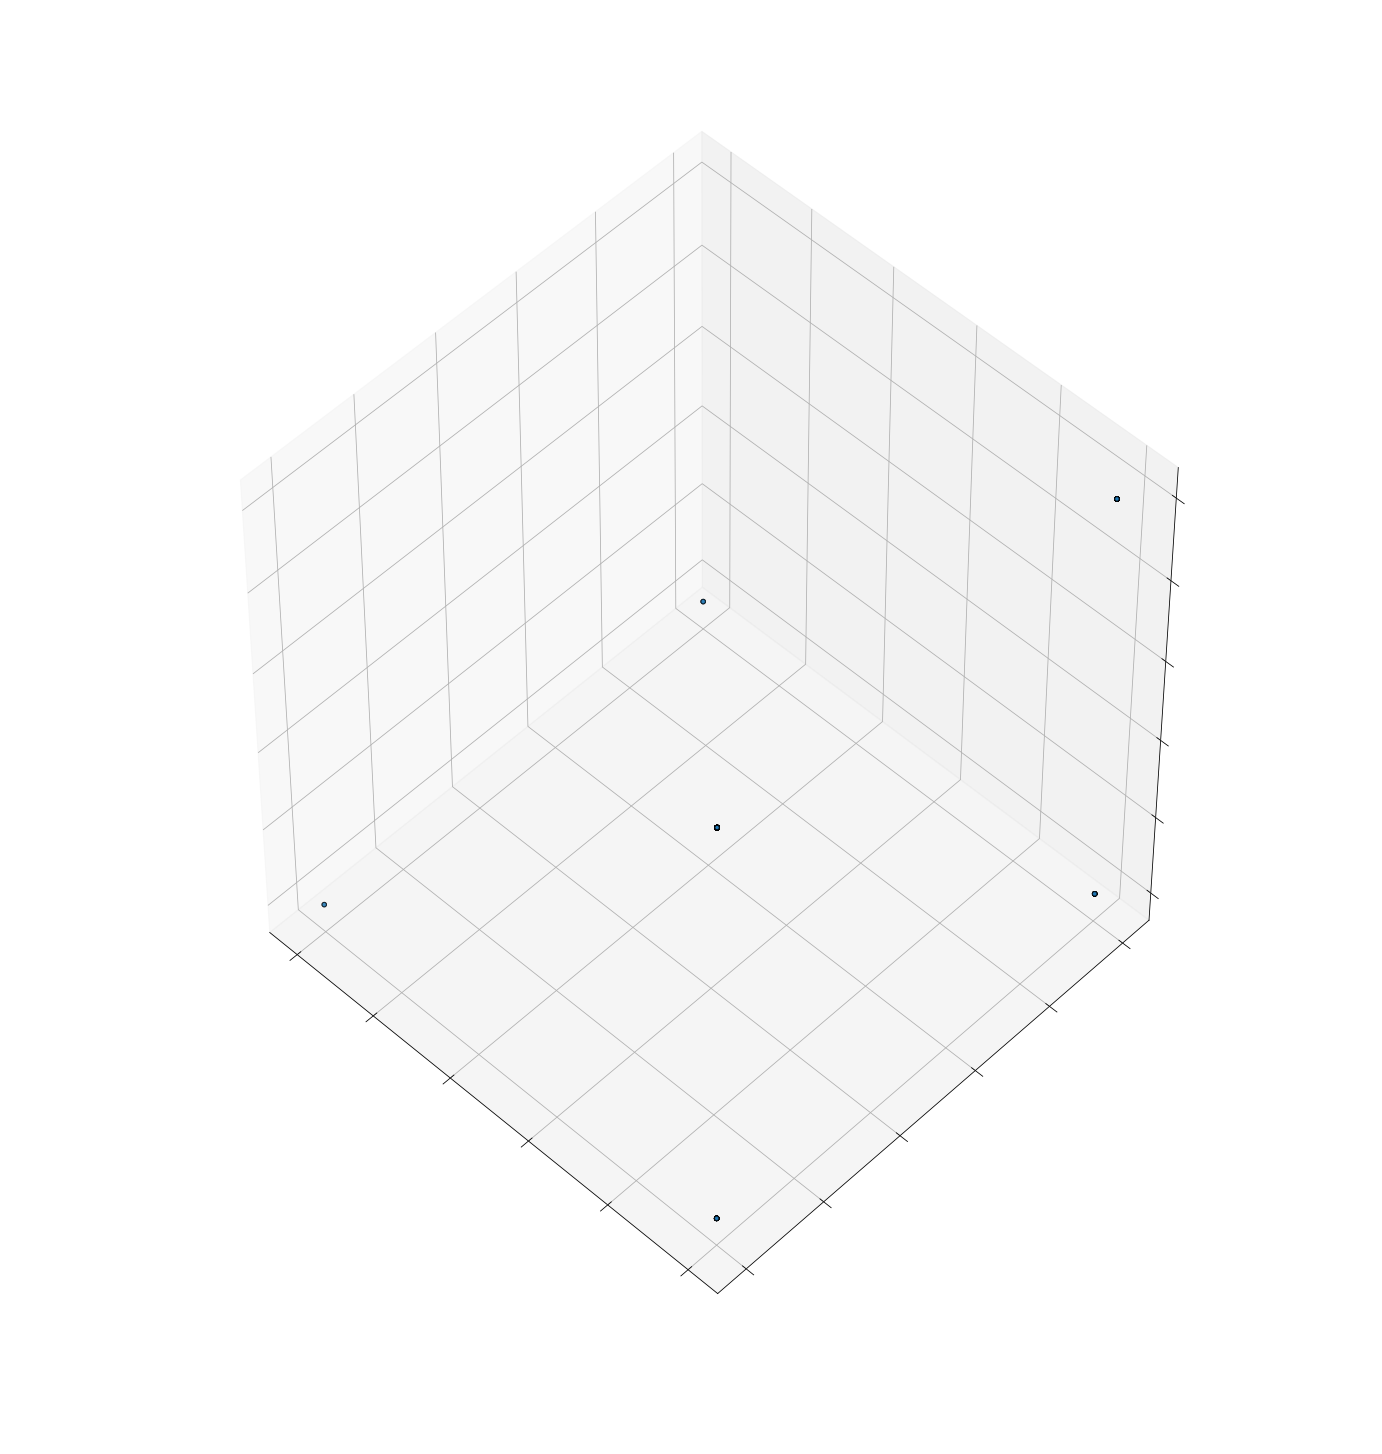

In [399]:
np.random.seed(5)
cluster = KMeans(n_clusters=2, random_state=RANDOM_STATE)

fig = plt.figure(1, figsize=(20, 20))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
cluster.fit(X)
labels = y

ax.scatter(X[:,3], X[:,0], X[:,2], edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.dist = 12

fig.show()

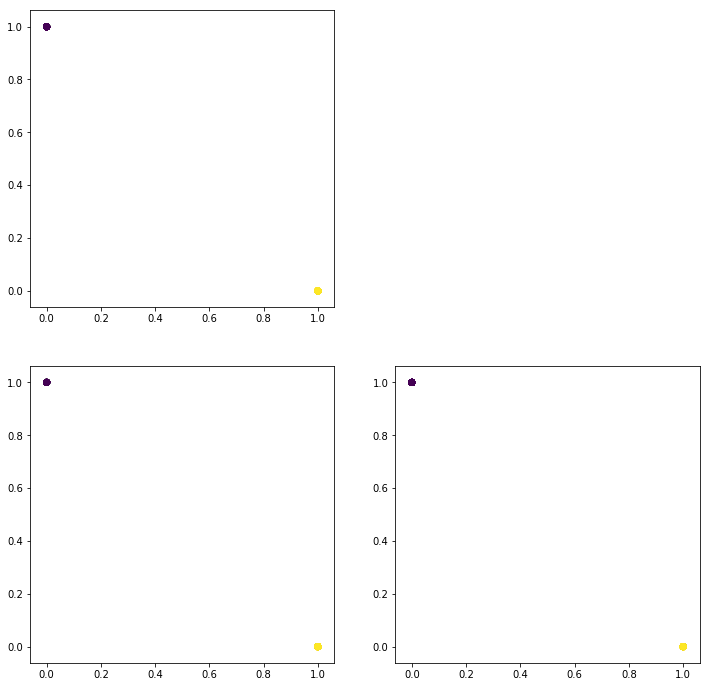

In [400]:
plt.figure(figsize=(12, 12))

y_pred = KMeans(n_clusters=2, random_state=random_state).fit_predict(X)

plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)

# Different variance
y_pred = KMeans(n_clusters=2, random_state=random_state).fit_predict(X)

plt.subplot(223)
plt.scatter(X[:,0], X[:, 1], c=y_pred)

# Unevenly sized blobs
y_pred = KMeans(n_clusters=2, random_state=random_state).fit_predict(X)
plt.subplot(224)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)

plt.show()